# Exercise 03

## 1 Introduction

<div style="color: green; font-weight: bold">
Your solution is correct. The sample solution however better splits the individual parts of the code into it's logical compartments.
</div>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
 
import torch 
import torch.optim as optim 
from torch.utils.data import DataLoader 
 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
 
from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape).to(device) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

In [3]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # move data to the GPU
        x, y = x.to(device), y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # move data to the GPU
                x, y = x.to(device), y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 4.01e-01
Mean Test Loss:  1.50e-01
Epoch: 10
Mean Train Loss: 1.46e-01
Mean Test Loss:  2.70e-01
Epoch: 20
Mean Train Loss: 9.45e-02
Mean Test Loss:  5.38e-01
Epoch: 30
Mean Train Loss: 8.14e-02
Mean Test Loss:  4.93e-01
Epoch: 40
Mean Train Loss: 4.67e-02
Mean Test Loss:  6.21e-01
Epoch: 50
Mean Train Loss: 4.18e-02
Mean Test Loss:  7.55e-01
Epoch: 60
Mean Train Loss: 2.44e-02
Mean Test Loss:  7.19e-01
Epoch: 70
Mean Train Loss: 2.56e-02
Mean Test Loss:  9.38e-01
Epoch: 80
Mean Train Loss: 1.89e-02
Mean Test Loss:  9.16e-01
Epoch: 90
Mean Train Loss: 1.32e-02
Mean Test Loss:  8.13e-01
Epoch: 100
Mean Train Loss: 7.88e-03
Mean Test Loss:  1.14e+00


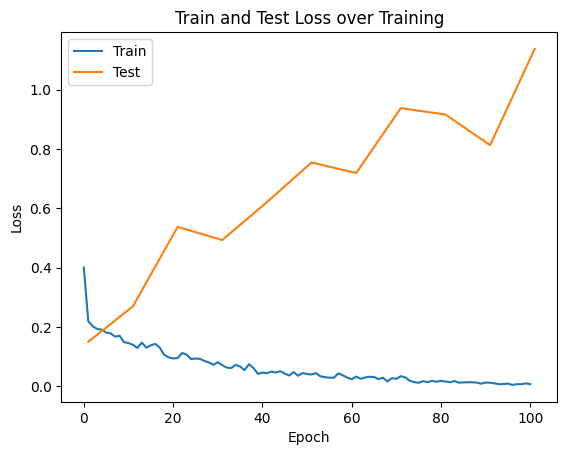

In [4]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 2 Dropout

<div style="color: green; font-weight: bold">
Your solution matches the sample solution perfectly </br>
Your answers to the questions also match the sample solution and are written really well
</div>

In [5]:
def dropout(x, p_drop=0.5):
    if 0.0 > p_drop or 1.0 < p_drop:
         ValueError(f"p_drop={p_drop} is not in 0. and 1.")
    if p_drop == 0.0:
        return x
    mask = torch.rand(x.size()) < p_drop
    x[mask] = 0
    return x / (1.0 - p_drop)

In [6]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input=0.0, p_drop_hidden=0.0):
    x = dropout(x, p_drop_input)
    h = rectify(x @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [7]:
# reinitialize weights
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
# reinitialize optimizer
optimizer = RMSprop(params=[w_h, w_h2, w_o])

p_drop_input = 0.2
p_drop_hidden = 0.2

In [8]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # move data to the GPU
        x, y = x.to(device), y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # move data to the GPU
                x, y = x.to(device), y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 5.33e-01
Mean Test Loss:  2.48e-01
Epoch: 10
Mean Train Loss: 3.58e-01
Mean Test Loss:  1.84e-01
Epoch: 20
Mean Train Loss: 4.19e-01
Mean Test Loss:  2.00e-01
Epoch: 30
Mean Train Loss: 4.50e-01
Mean Test Loss:  3.13e-01
Epoch: 40
Mean Train Loss: 4.76e-01
Mean Test Loss:  2.62e-01
Epoch: 50
Mean Train Loss: 4.98e-01
Mean Test Loss:  3.55e-01
Epoch: 60
Mean Train Loss: 5.43e-01
Mean Test Loss:  3.51e-01
Epoch: 70
Mean Train Loss: 5.65e-01
Mean Test Loss:  4.06e-01
Epoch: 80
Mean Train Loss: 5.91e-01
Mean Test Loss:  5.03e-01
Epoch: 90
Mean Train Loss: 6.51e-01
Mean Test Loss:  4.63e-01
Epoch: 100
Mean Train Loss: 6.89e-01
Mean Test Loss:  5.13e-01


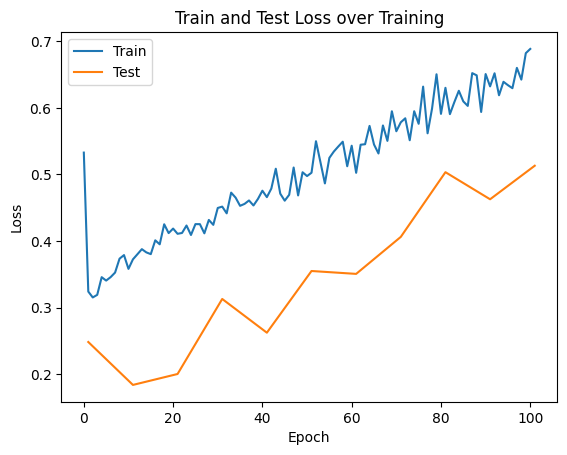

In [9]:

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Task:**

Explain in a few sentences how the dropout method works and how it reduces overfitting. Train the model using dropout and report train and test errors. Why do we need a different model configuration for evaluating the test loss? Compare the test error with the test error from Section 1.

**Answer:**
1. It works by randomly dropping out a subset of neurons during the training phase. This prevents the network from relying too heavily on any particular set of neurons, thus forcing it to learn more robust and generalized features. By randomly removing neurons, the network mimics training multiple different architectures and averages their results, which enhances its ability to generalize to unseen data.

2. During training, dropout is used to simulate a thinned network where only a subset of neurons is active. This helps in enhancing the generalization capabilities of the model. However, at test time, we want the network to leverage all the learned features and connections for best performance. Hence, dropout is disabled during testing, and the full network is utilized. This difference in configuration ensures that the model's full capacity is used to evaluate the real-world performance.

3. Using dropout, the model shows slightly higher training loss but significantly lower test loss, indicating improved generalization. Without dropout, the model exhibits minimal training loss but higher test loss, suggesting overfitting. Dropout effectively enhances model performance on unseen data by preventing over-reliance on specific features during training, thereby reducing overfitting. This comparison underscores dropout's value in improving neural network robustness, particularly in scenarios prone to overfitting.



## 3 Parametric Relu

<div style="color: green; font-weight: bold">
Your solution perfectly matches the sample solution
</div>

In [10]:
def PRelu(x, a): 
    return torch.where(x > 0, x, a * x)

In [11]:
def prelu_model(X, w_h, w_h2, w_o, a1, a2, p_drop_input=0.0, p_drop_hidden=0.0):
    X = dropout(X, p_drop_input)
    h = PRelu(X @ w_h, a1)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [12]:
def init_alpha(shape):
    a = torch.zeros(size=shape).to(device)
    a.requires_grad = True
    return a

In [13]:
w_h = init_weights((784, 625)) 
w_h2 = init_weights((625, 625)) 
w_o = init_weights((625, 10)) 
a1 = init_alpha((batch_size, 625)) 
a2 = init_alpha((batch_size, 625)) 

optimizer = RMSprop([w_h, w_h2, w_o, a1, a2]) 
 
p_drop_input = 0.2 
p_drop_hidden = 0.2

In [14]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # move data to the GPU
        x, y = x.to(device), y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = prelu_model(x, w_h, w_h2, w_o, a1, a2, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # move data to the GPU
                x, y = x.to(device), y.to(device)

                x = x.reshape(batch_size, 784)
                noise_py_x = prelu_model(x, w_h, w_h2, w_o, a1, a2)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 5.30e-01
Mean Test Loss:  2.52e-01
Epoch: 10
Mean Train Loss: 2.20e-01
Mean Test Loss:  1.90e-01
Epoch: 20
Mean Train Loss: 1.86e-01
Mean Test Loss:  1.22e-01
Epoch: 30
Mean Train Loss: 1.74e-01
Mean Test Loss:  1.36e-01
Epoch: 40
Mean Train Loss: 1.72e-01
Mean Test Loss:  1.40e-01
Epoch: 50
Mean Train Loss: 1.71e-01
Mean Test Loss:  1.38e-01
Epoch: 60
Mean Train Loss: 1.63e-01
Mean Test Loss:  2.26e-01
Epoch: 70
Mean Train Loss: 1.73e-01
Mean Test Loss:  1.43e-01
Epoch: 80
Mean Train Loss: 1.78e-01
Mean Test Loss:  1.75e-01
Epoch: 90
Mean Train Loss: 1.66e-01
Mean Test Loss:  1.68e-01
Epoch: 100
Mean Train Loss: 1.84e-01
Mean Test Loss:  2.02e-01


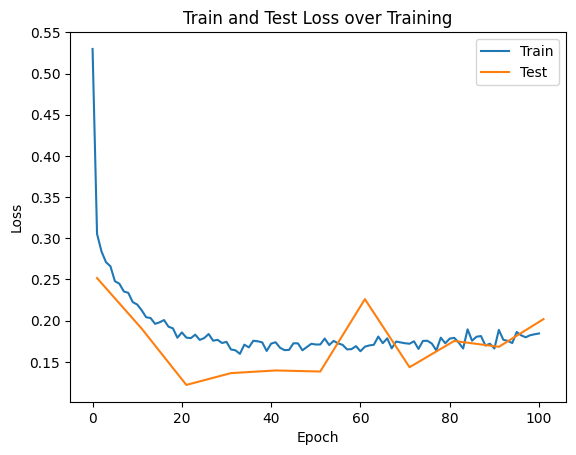

In [15]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Task:**

Compare the results with the previous models

**Answer:**

The implementation of the ReLU activation function in the neural network has led to a steady decrease in both training and test loss over 100 epochs, showcasing its effectiveness in facilitating convergence and improving model performance. The training loss decreases sharply initially and then gradually levels off, maintaining a close margin to the test loss throughout the training process. This indicates that the model with ReLU activation has managed to learn generalizable features effectively without significant overfitting. Compared to previous models, the ReLU-based model shows a more stable loss progression, suggesting better generalization on unseen data.



## 4 Convolutional Layers

<div style="color: green; font-weight: bold">
Comment:Your solution is exactly like the sample solution, additionally the comparison is explained well in detail
</div>

In [16]:
def conv_model(X, conv_w1, conv_w2, conv_w3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    conv1 = rectify(conv2d(X, conv_w1))
    pool1 = max_pool2d(conv1, (2, 2))
    drop1 = dropout(pool1, p_drop_hidden)

    conv2 = rectify(conv2d(drop1, conv_w2))
    pool2 = max_pool2d(conv2, (2, 2))
    drop2 = dropout(pool2, p_drop_hidden)

    conv3 = rectify(conv2d(drop2, conv_w3))
    pool3 = max_pool2d(conv3, (2, 2))
    drop3 = dropout(pool3, p_drop_hidden)

    h2 = rectify(torch.reshape(drop3, (batch_size, 128)) @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [17]:
conv_w1 = init_weights((32, 1, 5, 5)) 
conv_w2 = init_weights((64, 32, 5, 5)) 
conv_w3 = init_weights((128, 64, 3, 3)) 
w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10)) 
 
optimizer = RMSprop([conv_w1, conv_w2, conv_w3, w_h2, w_o]) 
 
p_drop_input = 0.1
p_drop_hidden = 0.1

In [18]:
n_epochs = 20 
 
train_loss = [] 
test_loss = [] 
 
for epoch in range(n_epochs + 1): 
    train_loss_this_epoch = [] 
    for idx, batch in enumerate(train_dataloader): 
        x, y = batch
        x, y = x.to(device), y.to(device)
 
        # convolutional model needs input (B, C, H, W) 
        # B = Batch Size, C = Number of Channels, H, W = Image Dimensions 
        x = x.reshape(-1, 1, 28, 28) 
        noise_py_x = conv_model(x, conv_w1, conv_w2, conv_w3, w_h2, w_o, p_drop_input, p_drop_hidden) 
 
        optimizer.zero_grad() 
        loss = cross_entropy(noise_py_x, y, reduction="mean") 
        train_loss_this_epoch.append(float(loss)) 
 
        loss.backward() 
        optimizer.step() 
 
    train_loss.append(np.mean(train_loss_this_epoch)) 
 
    if epoch % 2 == 0: 
        print(f"Epoch: {epoch}") 
        print(f"Mean Train Loss: {train_loss[-1]:.2e}") 
        test_loss_this_epoch = [] 
 
        with torch.no_grad(): 
            for idx, batch in enumerate(test_dataloader): 
                x, y = batch
                x, y = x.to(device), y.to(device)
                x = x.reshape(-1, 1, 28, 28) 
 
                noise_py_x = conv_model(x, conv_w1, conv_w2, conv_w3, w_h2, w_o, 0.0, 0.0) 
 
                loss = cross_entropy(noise_py_x, y, reduction="mean") 
                test_loss_this_epoch.append(float(loss)) 
 
        test_loss.append(np.mean(test_loss_this_epoch)) 
 
        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 1.43e+00
Mean Test Loss:  1.16e-01
Epoch: 2
Mean Train Loss: 1.78e-01
Mean Test Loss:  6.64e-02
Epoch: 4
Mean Train Loss: 1.73e-01
Mean Test Loss:  1.18e-01
Epoch: 6
Mean Train Loss: 2.04e-01
Mean Test Loss:  5.98e-02
Epoch: 8
Mean Train Loss: 2.08e-01
Mean Test Loss:  5.52e-02
Epoch: 10
Mean Train Loss: 2.23e-01
Mean Test Loss:  5.87e-02
Epoch: 12
Mean Train Loss: 2.19e-01
Mean Test Loss:  5.45e-02
Epoch: 14
Mean Train Loss: 2.23e-01
Mean Test Loss:  7.07e-02
Epoch: 16
Mean Train Loss: 2.34e-01
Mean Test Loss:  6.54e-02
Epoch: 18
Mean Train Loss: 2.44e-01
Mean Test Loss:  5.30e-02
Epoch: 20
Mean Train Loss: 2.40e-01
Mean Test Loss:  5.33e-02


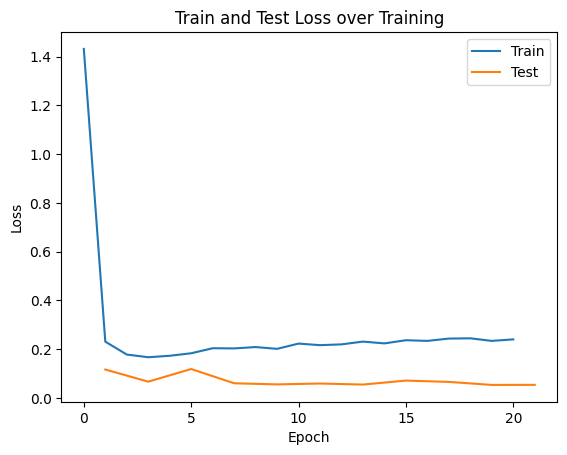

In [19]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train") 
plt.plot(np.arange(1, n_epochs + 2, 2), test_loss, label="Test") 
plt.title("Train and Test Loss over Training") 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend()
plt.show()

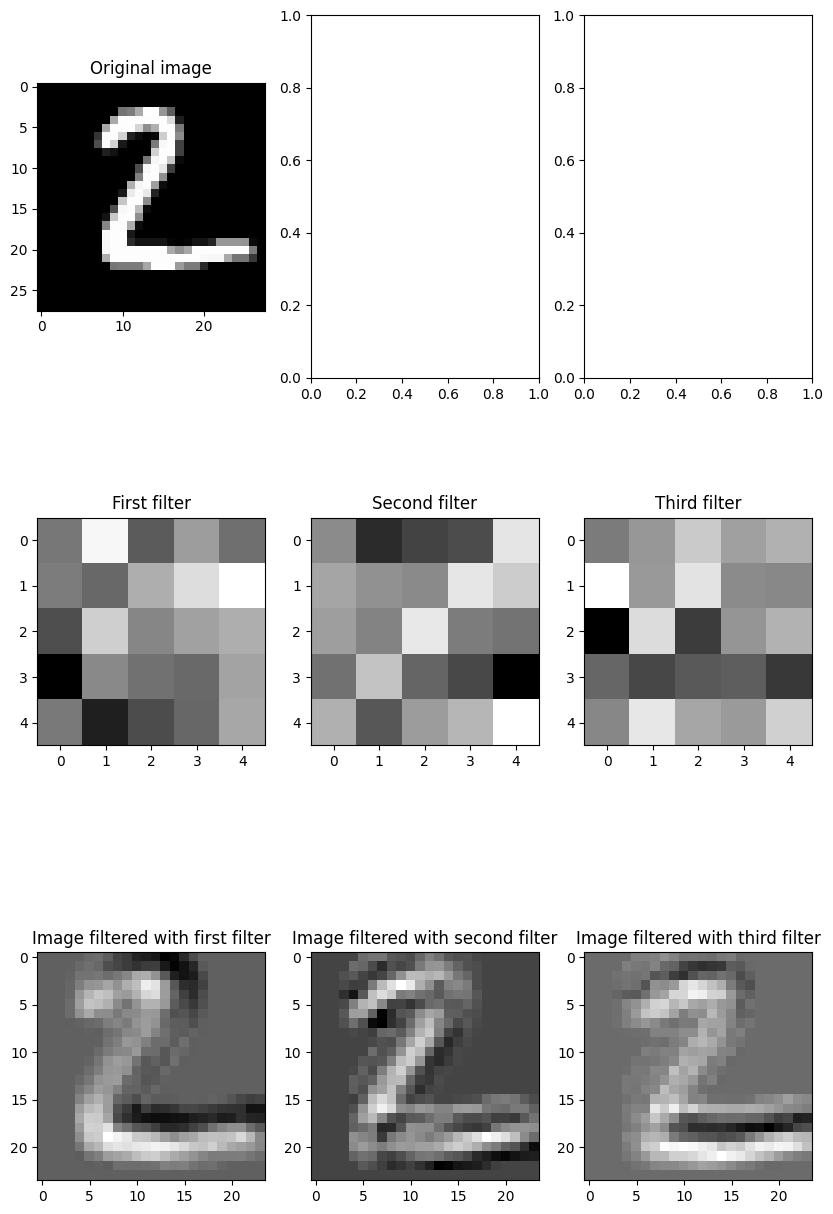

In [20]:
# get next batch
(data, label) = next(iter(test_dataloader)) 
 
# second image of batch
img_numpy = data[1, 0, :, :].numpy()

# three filters 
filter1_numpy = conv_w1[1, 0, :, :].detach().numpy() 
filter2_numpy = conv_w1[2, 0, :, :].detach().numpy() 
filter3_numpy = conv_w1[3, 0, :, :].detach().numpy() 
 
# convolution
conv1 = conv2d(data, conv_w1)

# the image convoluted with the filters
im_filter1 = conv1[1, 1, :, :].detach().numpy() 
im_filter2 = conv1[1, 2, :, :].detach().numpy() 
im_filter3 = conv1[1, 3, :, :].detach().numpy() 
 
# visualization 
fig, axes = plt.subplots(3, 3, figsize=(10, 16)) 
axes[0, 0].imshow(img_numpy, plt.cm.gray) 
axes[0, 0].set_title("Original image") 
axes[1, 0].imshow(filter1_numpy, plt.cm.gray) 
axes[1, 0].set_title("First filter") 
axes[1, 1].imshow(filter2_numpy, plt.cm.gray) 
axes[1, 1].set_title("Second filter") 
axes[1, 2].imshow(filter3_numpy, plt.cm.gray) 
axes[1, 2].set_title("Third filter") 
axes[2, 0].imshow(im_filter1, plt.cm.gray) 
axes[2, 0].set_title("Image filtered with first filter") 
axes[2, 1].imshow(im_filter2, plt.cm.gray) 
axes[2, 1].set_title("Image filtered with second filter") 
axes[2, 2].imshow(im_filter3, plt.cm.gray) 
axes[2, 2].set_title("Image filtered with third filter") 
plt.show()

In [21]:
conv_w1 = init_weights((32, 1, 6, 5)) 
conv_w2 = init_weights((64, 32, 5, 4)) 
conv_w3 = init_weights((128, 64, 2, 3)) 
w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10)) 
 
optimizer = RMSprop([conv_w1, conv_w2, conv_w3, w_h2, w_o]) 
 
p_drop_input = 0.1
p_drop_hidden = 0.1

In [22]:
n_epochs = 20 
 
train_loss = [] 
test_loss = [] 
 
for epoch in range(n_epochs + 1): 
    train_loss_this_epoch = [] 
    for idx, batch in enumerate(train_dataloader): 
        x, y = batch
        x, y = x.to(device), y.to(device)
 
        # convolutional model needs input (B, C, H, W) 
        # B = Batch Size, C = Number of Channels, H, W = Image Dimensions 
        x = x.reshape(-1, 1, 28, 28) 
        noise_py_x = conv_model(x, conv_w1, conv_w2, conv_w3, w_h2, w_o, p_drop_input, p_drop_hidden) 
 
        optimizer.zero_grad() 
        loss = cross_entropy(noise_py_x, y, reduction="mean") 
        train_loss_this_epoch.append(float(loss)) 
 
        loss.backward() 
        optimizer.step() 
 
    train_loss.append(np.mean(train_loss_this_epoch)) 
 
    if epoch % 2 == 0: 
        print(f"Epoch: {epoch}") 
        print(f"Mean Train Loss: {train_loss[-1]:.2e}") 
        test_loss_this_epoch = [] 
 
        with torch.no_grad(): 
            for idx, batch in enumerate(test_dataloader): 
                x, y = batch
                x, y = x.to(device), y.to(device)
                x = x.reshape(-1, 1, 28, 28) 
 
                noise_py_x = conv_model(x, conv_w1, conv_w2, conv_w3, w_h2, w_o, 0.0, 0.0) 
 
                loss = cross_entropy(noise_py_x, y, reduction="mean") 
                test_loss_this_epoch.append(float(loss)) 
 
        test_loss.append(np.mean(test_loss_this_epoch)) 
 
        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 1.05e+00
Mean Test Loss:  1.38e-01
Epoch: 2
Mean Train Loss: 1.95e-01
Mean Test Loss:  8.01e-02
Epoch: 4
Mean Train Loss: 2.00e-01
Mean Test Loss:  1.06e-01
Epoch: 6
Mean Train Loss: 2.19e-01
Mean Test Loss:  7.68e-02
Epoch: 8
Mean Train Loss: 2.31e-01
Mean Test Loss:  7.69e-02
Epoch: 10
Mean Train Loss: 2.43e-01
Mean Test Loss:  6.92e-02
Epoch: 12
Mean Train Loss: 2.59e-01
Mean Test Loss:  1.21e-01
Epoch: 14
Mean Train Loss: 2.55e-01
Mean Test Loss:  6.59e-02
Epoch: 16
Mean Train Loss: 2.59e-01
Mean Test Loss:  5.67e-02
Epoch: 18
Mean Train Loss: 2.63e-01
Mean Test Loss:  6.63e-02
Epoch: 20
Mean Train Loss: 2.68e-01
Mean Test Loss:  6.02e-02


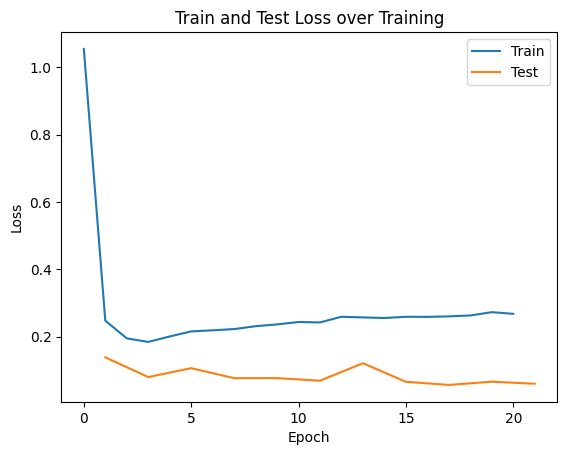

In [23]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train") 
plt.plot(np.arange(1, n_epochs + 2, 2), test_loss, label="Test") 
plt.title("Train and Test Loss over Training") 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.legend()
plt.show()

**Task:**

Compare the results with the previous models

**Answer:**

In testing, the test loss of the convolutional network with anisotropic filters is only slightly higher than that of the network with isotropic filters. Considering that the sizes of the anisotropic filters are not unusually large, this minor performance difference is reasonable. Although anisotropic filters can capture more directionally specific features, which might make the model perform better with certain types of image data, this advantage may not significantly reflect in the overall test loss. Therefore, despite the slight differences, both types of filters have demonstrated good generalization performance.